# Normalizing Flows Tutorial Part 1

2D invertible MLP on a toy dataset.

Copyright 2018 Eric Jang

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
tfd = tf.contrib.distributions
tfb = tfd.bijectors


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
tf.set_random_seed(0)

In [3]:
sess = tf.InteractiveSession()

In [4]:
batch_size=512
DTYPE=tf.float32
NP_DTYPE=np.float32

## Target Density

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


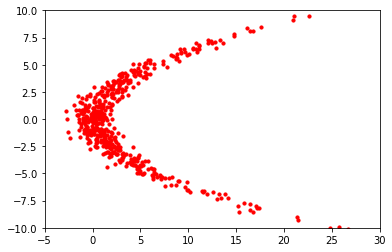

In [5]:
DATASET = 1
if DATASET == 0:
    mean = [0.4, 1]
    A = np.array([[2, .3], [-1., 4]])
    cov = A.T.dot(A)
    print(mean)
    print(cov)
    X = np.random.multivariate_normal(mean, cov, 2000)
    plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
    dataset = tf.data.Dataset.from_tensor_slices(X.astype(NP_DTYPE))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(buffer_size=X.shape[0])
    dataset = dataset.prefetch(3 * batch_size)
    dataset = dataset.batch(batch_size)
    data_iterator = dataset.make_one_shot_iterator()
    x_samples = data_iterator.get_next()
elif DATASET == 1:
    x2_dist = tfd.Normal(loc=0., scale=4.)
    x2_samples = x2_dist.sample(batch_size)
    x1 = tfd.Normal(loc=.25 * tf.square(x2_samples),
                    scale=tf.ones(batch_size, dtype=DTYPE))
    x1_samples = x1.sample()
    x_samples = tf.stack([x1_samples, x2_samples], axis=1)
    np_samples = sess.run(x_samples)
    plt.scatter(np_samples[:, 0], np_samples[:, 1], s=10, color='red')
    plt.xlim([-5, 30])
    plt.ylim([-10, 10])

## Construct Flow

In [6]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE))

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updatin

In [7]:
# quite easy to interpret - multiplying by alpha causes a contraction in volume.
class LeakyReLU(tfb.Bijector):
    def __init__(self, alpha=0.5, validate_args=False, name="leaky_relu"):
        super(LeakyReLU, self).__init__(
            event_ndims=1, validate_args=validate_args, name=name)
        self.alpha = alpha

    def _forward(self, x):
        return tf.where(tf.greater_equal(x, 0), x, self.alpha * x)

    def _inverse(self, y):
        return tf.where(tf.greater_equal(y, 0), y, 1. / self.alpha * y)

    def _inverse_log_det_jacobian(self, y):
        event_dims = self._event_dims_tensor(y)
        I = tf.ones_like(y)
        J_inv = tf.where(tf.greater_equal(y, 0), I, 1.0 / self.alpha * I)
        # abs is actually redundant here, since this det Jacobian is > 0
        log_abs_det_J_inv = tf.log(tf.abs(J_inv))
        return tf.reduce_sum(log_abs_det_J_inv, axis=event_dims)

In [8]:
d, r = 2, 2
bijectors = []
num_layers = 6
for i in range(num_layers):
    with tf.variable_scope('bijector_%d' % i):
        V = tf.get_variable('V', [d, r], dtype=DTYPE)  # factor loading
        shift = tf.get_variable('shift', [d], dtype=DTYPE)  # affine shift
        L = tf.get_variable('L', [d * (d + 1) / 2],
                            dtype=DTYPE)  # lower triangular
        bijectors.append(tfb.Affine(
            scale_tril=tfd.fill_triangular(L),
            scale_perturb_factor=V,
            shift=shift,
        ))
        alpha = tf.abs(tf.get_variable('alpha', [], dtype=DTYPE)) + .01
        bijectors.append(LeakyReLU(alpha=alpha))
# Last layer is affine. Note that tfb.Chain takes a list of bijectors in the *reverse* order
# that they are applied..
mlp_bijector = tfb.Chain(
    list(reversed(bijectors[:-1])), name='2d_mlp_bijector')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


TypeError: __init__() got an unexpected keyword argument 'event_ndims'

In [ ]:
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=mlp_bijector
)

## Visualization (before training)

In [ ]:
# visualization
x = base_dist.sample(512)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

In [ ]:
sess.run(tf.global_variables_initializer())

In [ ]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([-2, 2])
    arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])

## Optimize Flow

In [ ]:
loss = -tf.reduce_mean(dist.log_prob(x_samples))
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)

In [ ]:
sess.run(tf.global_variables_initializer())

In [ ]:
NUM_STEPS = int(1e5)
global_step = []
np_losses = []
for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op, loss])
    if i % 1000 == 0:
        global_step.append(i)
        np_losses.append(np_loss)
    if i % int(1e4) == 0:
        print(i, np_loss)
start = 10
plt.plot(np_losses[start:])

In [26]:
sess.run([loss])

[4.358737]

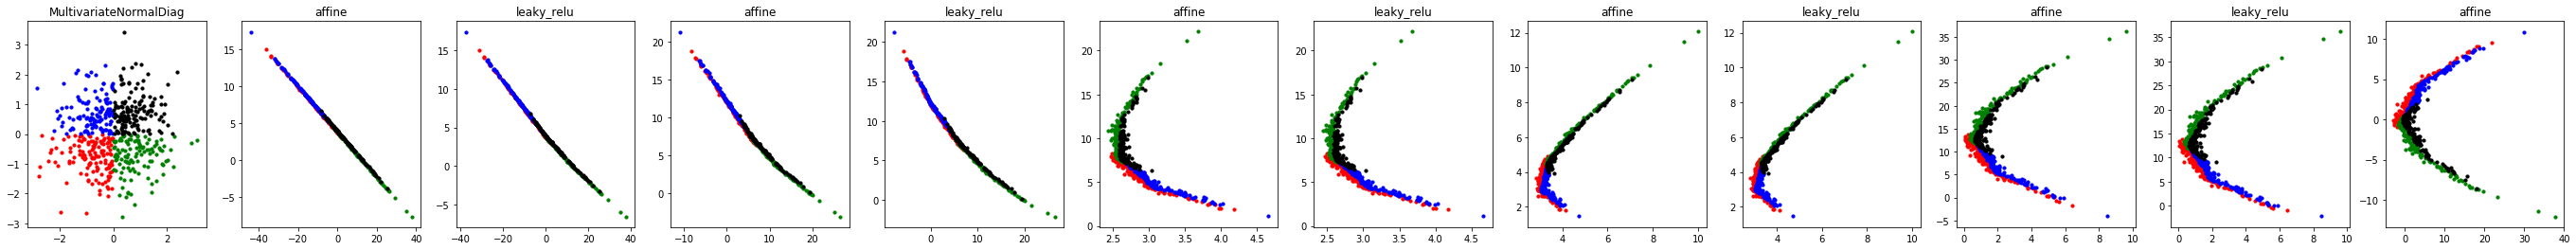

In [16]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    #arr[i].set_xlim([-2, 2])
    #arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])
plt.savefig('toy2d_flow.png', dpi=300)

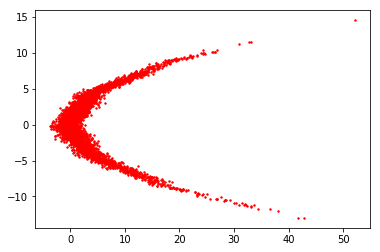

In [17]:
X1 = sess.run(dist.sample(4000))
plt.scatter(X1[:, 0], X1[:, 1], color='red', s=2)
arr[i].set_xlim([-2.5, 2.5])
arr[i].set_ylim([-.5, .5])
plt.savefig('toy2d_out.png', dpi=300)

In [ ]:
import pickle

In [ ]:
with open("bijector_params", "wb") as f:
    pickle.dump(dict([(v.name, sess.run(v)) for v in tf.trainable_variables()]), f)

In [ ]:
with open("bijector_params", "rb") as f:
    d = pickle.load(f)

In [ ]:
len(bijectors)

In [22]:
shifts = []

In [23]:
d, r = 2, 2

for i in range(num_layers):
    with tf.variable_scope('bijector_%d' % i, reuse=tf.AUTO_REUSE):
        V = tf.get_variable('V')  # factor loading
        L = tf.get_variable('L')  # lower triangular
        shifts.append(sess.run(tf.get_variable("shift")))
        
        print(f"\nA_{i}: ")
        print(sess.run(
            tfd.fill_triangular(L) + 
            V @ tf.eye(2) @ tf.transpose(V)
        ))


A_0: 
[[12.666909  -3.2123168]
 [-3.8751755  1.0632172]]

A_1: 
[[0.8707053 1.1683432]
 [0.0598104 1.2055824]]

A_2: 
[[0.2163449 0.3574212]
 [0.875208  0.3780005]]

A_3: 
[[1.7268234  0.33141184]
 [0.10429177 0.50915474]]

A_4: 
[[ 2.8008046 -1.29002  ]
 [-1.6140362  4.5898643]]

A_5: 
[[ 4.045219    0.08481489]
 [ 0.25647464 -0.6058725 ]]


In [25]:
d, r = 2, 2

for i in range(num_layers):
    with tf.variable_scope('bijector_%d' % i, reuse=tf.AUTO_REUSE):
        L = tf.get_variable('L')  # lower triangular
        
        print(f"\nL_{i}: \n{sess.run(L)}")
        
for i in range(num_layers):
    with tf.variable_scope('bijector_%d' % i, reuse=tf.AUTO_REUSE):
        V = tf.get_variable('V')  # factor loading
        print(f"\nV_{i}: \n{sess.run(V)}")


L_0: 
[ 0.19130541 -0.66285866  0.635223  ]

L_1: 
[-0.21493493 -1.1085328  -0.09023035]

L_2: 
[-0.97976303  0.51778686 -0.58213425]

L_3: 
[-0.5339833  -0.22712007  0.37868443]

L_4: 
[ 0.9055861  -0.32401618  0.01458302]

L_5: 
[-0.7340774   0.17165975 -0.17290545]

V_0: 
[[-1.9192145  -2.8893428 ]
 [ 0.61188304  0.7053445 ]]

V_1: 
[[-1.6655174e-36  9.8027325e-01]
 [ 2.7752662e-36  1.1918546e+00]]

V_2: 
[[-0.2731575   0.85080206]
 [ 0.91976583  0.715398  ]]

V_3: 
[[-0.78363204 -0.8567729 ]
 [ 0.5309808  -0.87246627]]

V_4: 
[[-0.7394123   1.4964929 ]
 [ 1.9175456   0.08542425]]

V_5: 
[[2.0492299  0.13704464]
 [0.01747171 0.35763052]]


In [ ]:
prev = np.array([1, 0], dtype=np.float32)

for i, bij in enumerate(reversed(mlp_bijector._bijectors)):
    print(prev)
    next_ = sess.run(
        bij.forward(prev)
    )
    prev = next_
        
print(prev)

In [ ]:
As = [
    [[12.666909,  -3.2123168],
     [-3.8751755,  1.0632172]],

    [[0.8707053, 1.1683432],
     [0.0598104, 1.2055824]],

    [[0.2163449, 0.3574212],
     [0.875208,  0.3780005]],

    [[1.7268234,  0.33141184],
     [0.10429177, 0.50915474]],

    [[ 2.8008046, -1.29002  ],
     [-1.6140362,  4.5898643]],

    [[ 4.045219,    0.08481489],
     [ 0.25647464, -0.6058725 ]],
]
matrices = list(map(np.array, As))

In [ ]:
prev = np.array([1, 0], dtype=np.float32)
bijs = list(reversed(mlp_bijector.bijectors))
alphas = []
for i, (shift, A) in enumerate(zip(shifts[:-1], As[:-1])):
    print(prev)
    prev = sess.run(A @ prev + shift)
    print(prev)
    prev = sess.run(bijs[i*2 + 1].forward(prev))
    alphas.append(bijs[i*2 + 1].alpha)
print(prev)
prev = sess.run(As[-1] @ prev + shifts[-1])
print(prev)


In [ ]:
sess.run(mlp_bijector.forward(np.array([1, 0], dtype=np.float32)))

In [ ]:
As

In [24]:
shifts

[array([-2.7384284,  4.6790996], dtype=float32),
 array([1.4246637, 2.5997574], dtype=float32),
 array([-1.2736514 , -0.14639635], dtype=float32),
 array([-3.702082  ,  0.40250754], dtype=float32),
 array([-2.8402073, -3.1306276], dtype=float32),
 array([-4.177382,  7.369329], dtype=float32)]

In [ ]:
sess.run(alphas)

In [ ]:
As[0]

In [ ]:
sess.run(shifts[0])

In [70]:
sess.run(mlp_bijector
         .forward_log_det_jacobian(
             np.array([1., 1.], dtype=np.float32)
         ))

1.647172